<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Multinomial_Models/Example_Multinomial_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

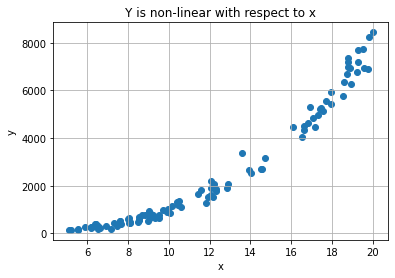

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a sample dataset
x = np.random.uniform(low=5, high=20, size=100)
e = np.random.normal(loc=0, scale=0.5, size=100)
y = (x + e)**3

fig, ax = plt.subplots(1,1)
ax.scatter(x,y)
ax.set_title('Y is non-linear with respect to x')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
fig.show()


In [2]:
# build a ridge regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

x = x.reshape(x.shape[0],1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

rgr = Ridge()
rgr.fit(x_train, y_train)
y_test_pred = rgr.predict(x_test)
mae = mean_absolute_error(y_test, y_test_pred)
print(f'MAE: {mae:.2f}')

MAE: 591.20


In [3]:
# transforming the target variable
class YTransformer:
  def __init__(self, power=1):
      self.power = power

  def fit(self, x, y):
    pass

  def transform(self, x, y):
    return x, np.power(y, self.power)

  def inverse_transform(self, x, y):
    return x, np.power(y, 1/self.power)
  
  def fit_transform(self, x, y):
    return self.transform(x, y)

In [4]:
from sklearn.metrics import r2_score

for power in [1, 1/2, 1/3, 1/4, 1/5]:
  yt = YTransformer(power)
  _, y_train_t = yt.fit_transform(None, y_train)
  _, y_test_t = yt.transform(None, y_test)
  rgs = Ridge()
  rgs.fit(x_train, y_train_t)
  y_pred_t = rgs.predict(x_test)
  _, y_pred = yt.inverse_transform(None, y_pred_t)
  print(
      'Transformed y^{:.2f}: MAE={:.0f}, R2={:.2f}'.format(
          power, mean_absolute_error(y_test, y_pred),
          r2_score(y_test, y_pred)
      )
  )

Transformed y^1.00: MAE=591, R2=0.92
Transformed y^0.50: MAE=298, R2=0.97
Transformed y^0.33: MAE=240, R2=0.99
Transformed y^0.25: MAE=228, R2=0.99
Transformed y^0.20: MAE=247, R2=0.98


In [5]:
# Estimating multiple regression targets
# Builing a multi-output regressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor

x, y = make_regression(n_samples=500, n_features=8, n_informative=8, n_targets=3, noise=30.0)
feature_names = [f'Feature # {i}' for i in range(x.shape[1])]
target_names = [f'Target # {i}' for i in range(y.shape[1])]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

rgr = MultiOutputRegressor(estimator=SGDRegressor(), n_jobs=-1)
rgr.fit(x_train, y_train)
y_pred = rgr.predict(x_test)

df_pred = pd.DataFrame(y_pred, columns=target_names)
df_pred.head(3)

,Target # 0,Target # 1,Target # 2
0,73.870655,-37.714489,-120.296827
1,132.267472,65.495037,-61.998836
2,227.996173,427.268549,227.792681


In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

for t in range(y_train.shape[1]):
  print('Target # {}: MAE={:.2f}, R2={:.2f}'.format(
      t, mean_absolute_error(y_test[t], y_pred[t]),
      r2_score(y_test[t], y_pred[t])
  ))

Target # 0: MAE=30.66, R2=0.82
Target # 1: MAE=28.42, R2=0.77
Target # 2: MAE=18.37, R2=0.97


In [7]:
# Chaining multiple regressors
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import Ridge

rgr = RegressorChain(base_estimator=Ridge(alpha=1), order=[0,1,2])
rgr.fit(x_train, y_train)
y_pred = rgr.predict(x_test)

pd.DataFrame(zip(rgr.estimators_[-1].coef_, feature_names + target_names),
             columns=['Coeff', 'Feature'])[['Feature', 'Coeff']].style.bar(
                 subset=['Coeff'], align='mid', color='#AAAAAA'
             )

,Feature,Coeff
0,Feature # 0,7.468460
1,Feature # 1,64.908130
2,Feature # 2,29.079833
3,Feature # 3,30.851227
4,Feature # 4,25.438057
5,Feature # 5,75.606101
6,Feature # 6,34.348010
7,Feature # 7,49.734896
8,Target # 0,0.031274
9,Target # 1,0.029788


In [8]:
# Compound classification targets
# Converting a multi-class problem into a set of binary classifiers
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

x, y = make_classification(n_samples=5000, n_features=15, n_informative=8, 
                           n_redundant=2, n_classes=4, class_sep=0.5)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

clf = OneVsRestClassifier(estimator=LogisticRegression(solver='saga'))
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(f'One vs Rest classifier accuracy score: {accuracy_score(y_test, y_pred):.2f}')

clf2 = OneVsOneClassifier(estimator=LogisticRegression(solver='saga'))
clf2.fit(x_train, y_train)
y_pred = clf2.predict(x_test)

print(f'One vs One classifier accuracy score: {accuracy_score(y_test, y_pred):.2f}')

One vs Rest classifier accuracy score: 0.36
One vs One classifier accuracy score: 0.37


In [9]:
# Estimating multiple classification targets
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier

x, y = make_multilabel_classification(n_samples=500, n_features=8, n_classes=3,
                                      n_labels=2)

y[:,-1] = y[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

clf = MultiOutputClassifier(estimator=GradientBoostingClassifier(
    n_estimators=500, learning_rate=0.01, subsample=0.8), n_jobs=-1
)

clf.fit(x_train, y_train)
y_pred_multioutput = clf.predict(x_test)
print(f'Multi-output classifier accuracy score: {accuracy_score(y_test, y_pred_multioutput):.2f}')

Multi-output classifier accuracy score: 0.66


In [10]:
# ClassifierChain
from sklearn.multioutput import ClassifierChain

clf = ClassifierChain(
    base_estimator=GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.01,
        subsample=0.8
    ),
    order=[0,1,2]
)
clf.fit(x_train, y_train)
y_pred_chain = clf.predict(x_test)
print(f' classifier Chain accuracy score: {accuracy_score(y_test, y_pred_chain):.2f}')


 classifier Chain accuracy score: 0.67


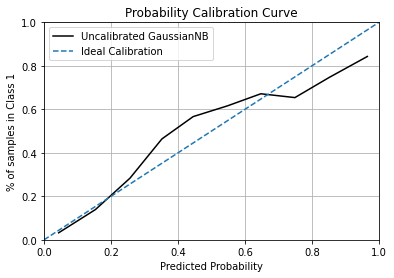

In [18]:
# Calibrating a classifier's probabilities
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve

x, y = make_classification(n_samples=50000, n_features=15, n_informative=5, 
                           n_redundant=10, n_classes=2, class_sep=0.001)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred_proba = clf.predict_proba(x_test)[:,-1]

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba, n_bins=10
)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(mean_predicted_value, fraction_of_positives, "-",
        label='Uncalibrated GaussianNB', color='k')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_title('Probability Calibration Curve')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('% of samples in Class 1')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls='--', label='Ideal Calibration')
ax.grid()
ax.legend()
fig.show()

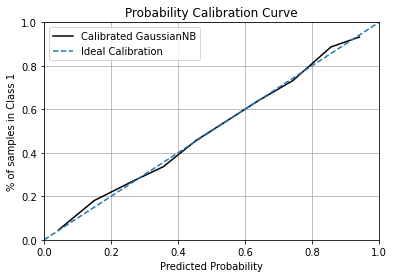

In [19]:
from sklearn.calibration import CalibratedClassifierCV

clf_calib = CalibratedClassifierCV(GaussianNB(), cv=3, method='isotonic')
clf_calib.fit(x_train, y_train)
y_pred_calib = clf_calib.predict(x_test)
y_pred_proba_calib = clf_calib.predict_proba(x_test)[:,-1]

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba_calib, n_bins=10
)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(mean_predicted_value, fraction_of_positives, "-",
        label='Calibrated GaussianNB', color='k')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_title('Probability Calibration Curve')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('% of samples in Class 1')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls='--', label='Ideal Calibration')
ax.grid()
ax.legend()
fig.show()

In [20]:
# Calculating precision at the top k samples
def precision_at_k_score(y_true, y_pred_proba, k=1000, pos_label=1):
  topk = [
          y_true_ == pos_label
          for y_true_, y_pred_proba_ in sorted(
              zip(y_true, y_pred_proba),
              key=lambda y: y[1],
              reverse=True
          )[:k]
  ]
  return sum(topk)/len(topk)

print(precision_at_k_score(y_test, y_pred_proba, k=500))

0.914
